# ◆[Kickstarter Projects](https://www.kaggle.com/kemical/kickstarter-projects)
### 目的：クラウドファンディングが成功するかを事前に予測する
##### Create Date：2020/02/02　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

#### 【手順】
0. [**Notebook内で利用する関数の定義**](#import_module)
1. [**データ読込**](#import_data)
2. [**特徴抽出**](#feature_extraction)
3. [**データ前処理**](#prepearing)
4. [**特徴選択**](#selection)
5. [**モデル構築**](#modeling)
6. [**学習曲線**](#learning_curve)
7. [**重要な特徴**](#feature_importance)
8. [**モデル評価**](#result)

##### ※「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | ID| 識別ID | - | ×予測に不要と考えられる為、除外 |
|  2 | name |名称 | 欠損あり | ○※文字数,単語数,最終文字を利用 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日 | - | ○※期間算出,月,日を算出 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使う為、除外 |
|  8 | launched |開始日時 | - | ○※期間算出,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | ×予測時に利用できない為、除外 |
| 10 | state |プロジェクトの状態 | - | ◎※目的変数で利用（成功と失敗のみ抽出） |
| 11 | backers |支援者数 | - | ×予測時に利用できない為、除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | ×予測時に利用できない為、除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | ×予測時に利用できない為、除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |

## 0.Notebook内で利用する関数の定義<a id='import_module'></a>

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
import xgboost           as xgb
import lightgbm          as lgb
from time                      import time
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split
from sklearn.model_selection   import KFold
from sklearn.model_selection   import GridSearchCV
from sklearn.linear_model      import SGDClassifier
from sklearn.svm               import SVC
from sklearn.tree              import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble          import RandomForestClassifier
from sklearn.ensemble          import ExtraTreesClassifier
from sklearn.ensemble          import AdaBoostClassifier
from sklearn.ensemble          import GradientBoostingClassifier
from sklearn.ensemble          import VotingClassifier
from xgboost.sklearn           import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection   import learning_curve
from sklearn.model_selection   import validation_curve
from sklearn.metrics           import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用
squeeze_num = 11000

decorr_flg = True # 無相関化するか
wrapper_flg = False # ラッパー法（ステップワイズ法）実施するか
selectFromModel_flg = True # 埋め込み法を実施するか

# 表示用
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 15)

# ============================================================================
# 結果をテキストファイルへ出力
# ============================================================================
def f_write(string):
    f = open('./result.txt', 'a') #追記
    dt_now = datetime.datetime.now()
    f.write('\n'+ dt_now.strftime('%Y/%m/%d %H:%M:%S') + '： ' + string) 
    f.close()
    
# ============================================================================
# 関数：成功と失敗別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    print('\n▼ ' + str(col_name) + 'の分布 ※歪度：' + str(df[col_name].skew()))
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['state']==0][col_name],kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(df[df['state']==1][col_name],kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：対数変換した成功と失敗別のヒストグラム
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram_log1p(col_name,w,h,bins_val):
    print('\n▼ 対数変換した' + str(col_name) + 'の分布')
    plt.figure(figsize=(w,h))
    sns.distplot(np.log1p(df[df['state']==0][col_name]),kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(np.log1p(df[df['state']==1][col_name]),kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name)
    plt.legend()
    plt.show()
    
# ============================================================================
# 関数：成功と失敗別に散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_scatter_plot(col_name, w, h):
    print('\n▼ ' + str(col_name) + 'の散布図')
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1.index, data1[col_name], 'o', color='C1', label='successful')
    plt.plot(data2.index, data2[col_name], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.ylabel(col_name)
    plt.xlabel('row_index')
    plt.show()
    
# ============================================================================
# 関数：2項目の相関関係と成功失敗を色分けして散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_corr_scatter_plot(col_name1, col_name2, w, h):
    print('\n▼ ' + str(col_name1) + ' と ' + str(col_name2) + ' の相関 ※相関係数: {:.3f}'.format(
    np.corrcoef(df[col_name1].values,df[col_name2].values)[0,1]))
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1[col_name1], data1[col_name2], 'o', color='C1', label='successful')
    plt.plot(data2[col_name1], data2[col_name2], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name1) + ' and ' + str(col_name2))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name1)
    plt.ylabel(col_name2)
    plt.show()

# ============================================================================
# 関数：成功数と失敗数別にカウント表示するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無、xラベルの回転
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False, x_rot = 0):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数（降順）')
        ax = sns.countplot(df[col_name],hue=df['state'],order = df[col_name].value_counts().index)
    else:
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数')
        ax = sns.countplot(df[col_name],hue=df['state'])
        
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：成功率を棒グラフで比較するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無、xラベルの回転
# ============================================================================
def show_successrate_barplot(col_name, w, h, baseline, sort_flg=False, x_rot = 0):
    # stateの平均値が成功率になる（成功率＝成功の件数/全体の件数）
    successrate = pd.DataFrame(df['state'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('state', ascending=False) # 成功率の降順
        print('\n▼ ' + str(col_name) + '別の成功率（降順）※赤線：学習データの平均成功率')
    else:
        print('\n▼ ' + str(col_name) + '別の成功率 ※赤線：学習データの平均成功率')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="state", data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('Success rate by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.show()

# ============================================================================
# 学習曲線を作成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# ============================================================================
# 特徴量の重要度を表示するグラフ
# ============================================================================
def plot_feature_importance(best_model, datacols, title):
    plt.figure(figsize=(8,4))
    tmp_se = pd.Series(best_model.feature_importances_,datacols).sort_values(ascending=True)
    tmp_se.tail(15).plot.barh(width=0.8)
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.title(title + ' (Top15)')
    plt.show()
    
# ============================================================================
# ハイパーパラメーター探索用関数
# ============================================================================
def grid_search_argo(dic_argo, model_name, clf, param, X_train, y_train):
    
    # グリッドサーチ
    grid = GridSearchCV(estimator=clf, param_grid=param, scoring='accuracy', cv=kfold, n_jobs=-1)
    
    # 学習
    grid_result = grid.fit(X_train, y_train)

    best_estimator = grid_result.best_estimator_
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    #for mean, stdev, param in zip(means, stds, params):
    #    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    #    print("----------------------------------------------")
    
    print("BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    dic_argo.setdefault(model_name, grid_result) # 辞書に格納
    
    return best_estimator

# ============================================================================
# 検証曲線
# ============================================================================
def v_curve(model,param,param_range):
    train_scores,test_scores = validation_curve(
        model,
        X_train,
        y_train,
        param_name=param,
        param_range=param_range,
        cv=10,
        scoring="accuracy",
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    
    #訓練セットスコアとテストセットスコアの平均精度スコアをプロット
    plt.figure(figsize=(6,3))
    plt.plot(param_range,train_mean,label="Training score",color="blue")
    plt.plot(param_range,test_mean,label="Cross-validation score",color="orange")
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    
    plt.title("Validationn Curve With RF " + str(param))
    plt.xlabel = (param)
    plt.ylabel = ("Accuracy_Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

# 1.データ読込<a id='import_data'><a>

In [2]:
f_write('\n-------------------------------------------------------------------')
f_write('▼処理開始')

df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

print('\n▼ 先頭3行表示')
display(df.head(3))

print('\n▼ 基本統計量')
display(df.describe())

print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))


▼ 先頭3行表示


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00



▼ 基本統計量


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08



▼ 欠損データ確認


,Missing num
name,4
usd pledged,3797


# 2. 特徴抽出<a id='feature_extraction'></a>
## 2-1. 説明変数の選定


▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化


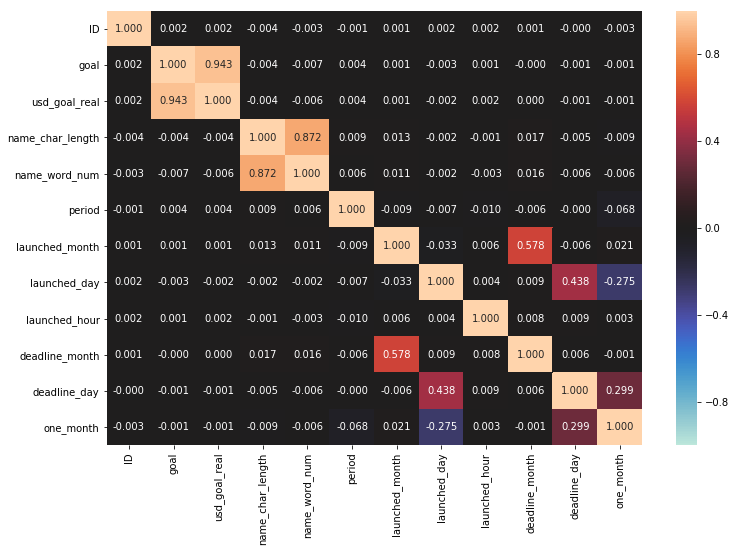

→フィルタ法にてgoalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。
→name_word_numとname_char_lengthは、正の相関があるので無相関化を検討する。


In [3]:
# 予測時に利用できない項目を削除
df = df.drop(['backers'], axis=1)          # 集客数は予測時に利用できない為、除外
df = df.drop(['pledged'], axis=1)          # 集まった資金は予測時に利用できない為、除外
df = df.drop(['usd pledged'], axis=1)      # 欠損があり、集まった資金は予測時に利用できない為、除外
df = df.drop(['usd_pledged_real'], axis=1) # 集まった資金は予測時に利用できない為、除外

# 説明変数になりそうな項目を追加
df['name_char_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', ''))) # nameの文字数
df['name_word_num'] = df['name'].apply(lambda x: len(str(x).split(' ')))          # nameの単語数   ・・・追加
df['name_end_char'] = df['name'].apply(lambda x: str(x).replace(' ', '')[-1])     # nameの最終文字 ・・・追加

df['period'] = (df['deadline'] - df['launched']).dt.days  # 開始日時と終了日から期間を算出

df['launched_month'] = df['launched'].dt.month            # 開始時期の月に着目
df['launched_day'] = df['launched'].dt.day                # 開始時期の日に着目
df['launched_hour'] = df['launched'].dt.hour              # 開始時期の時間に着目

df['deadline_month'] = df['deadline'].dt.month            # 終了時期の月に着目・・・追加
df['deadline_day'] = df['deadline'].dt.day                # 終了時期の日に着目・・・追加

df['one_month'] = np.where(df['launched_month'] == df['deadline_month'],1,0) # 同一の月内で完了しているか・・追加

# ヒートマップ
print('\n▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化')
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.show()
print('→フィルタ法にてgoalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。')
print('→name_word_numとname_char_lengthは、正の相関があるので無相関化を検討する。')

# 説明変数にはならなそうな項目を除外
df = df.drop(['ID'], axis=1)               # 不要と考え除外
df = df.drop(['name'], axis=1)             # 欠損があり、説明変数にするには難しいと思われるので除外
df = df.drop(['goal'], axis=1)             # usd_goal_realとほぼ等しい為、除外

# 抽出元の不要な項目を削除
df = df.drop(['launched'], axis=1)
df = df.drop(['deadline'], axis=1)

## 2-2. 目的変数の確認


▼ 目的変数 stateの種類（%）


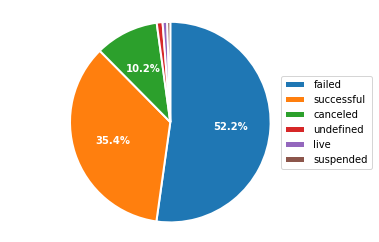

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。

▼ stateが成功または失敗のデータを抽出


,state
failed,197719
successful,133956



▼ 成功率の平均値
baseline= 0.4038772895153388


In [4]:
print('\n▼ 目的変数 stateの種類（%）')
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

# stateが成功または失敗のデータを抽出
df = df.query('state in ["successful", "failed"]')

print('\n▼ stateが成功または失敗のデータを抽出')
display(pd.DataFrame(df['state'].value_counts(),columns=['state']))

# 変換（成功=1，失敗=0）
df['state'] = df['state'].map({'failed': 0,'successful': 1})

# 成功率の平均
print('\n▼ 成功率の平均値')
baseline = df['state'].mean()
print('baseline=',baseline)

## 2-3. 各説明変数と目的変数の関係を確認
### 2-3-1. 期間（period）


▼ periodの分布 ※歪度：1.2535940368557628


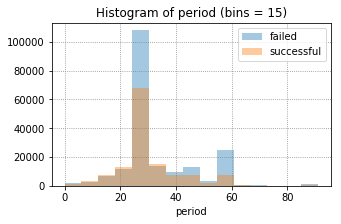

→失敗よりも成功が多い期間がある。

▼ period別の成功数と失敗数


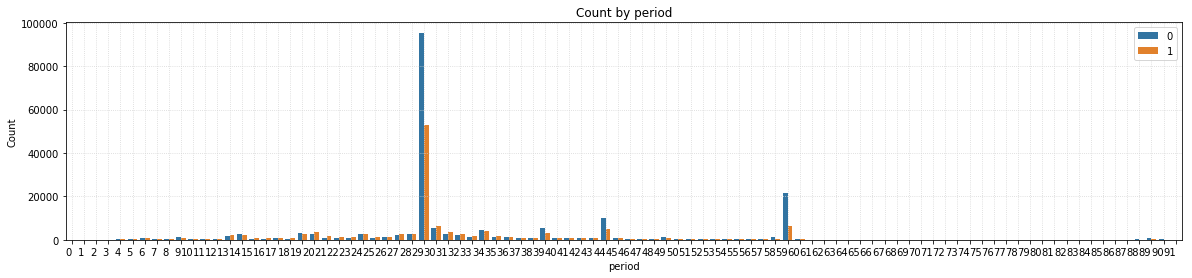

→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。

▼ period別の成功率 ※赤線：学習データの平均成功率


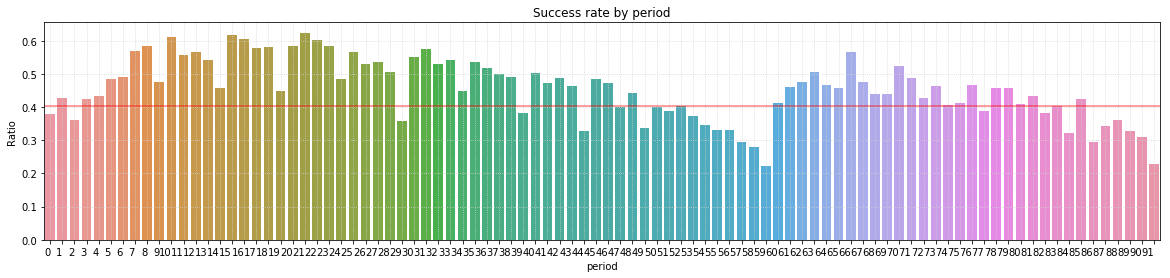

→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。


In [5]:
show_histogram('period',5,3,15)
print('→失敗よりも成功が多い期間がある。')

# 期間(日数)の分布を確認
show_state_count_plot('period',20,4)
print('→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。')

# 期間(日数)別の成功率を確認
show_successrate_barplot("period",20,4,baseline,False)
print('→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。')

### 2-3-2. 同一の月内で完了しているか（one_month）


▼ one_month別の成功数と失敗数


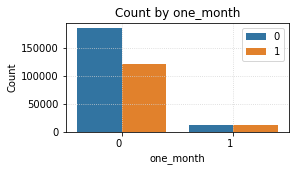


▼ one_month別の成功率 ※赤線：学習データの平均成功率


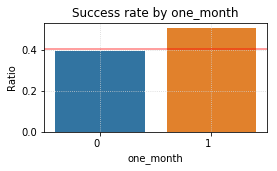

→ひと月以内で終了したほうが、成功率はあがる。


In [6]:
show_state_count_plot('one_month',4,2)
show_successrate_barplot("one_month",4,2,baseline,False)
print('→ひと月以内で終了したほうが、成功率はあがる。')

### 2-3-3. 目標金額（usd_goal_real）


▼ usd_goal_realの散布図


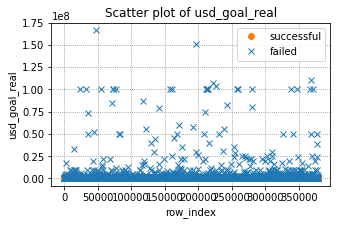

→目標金額が高すぎるものは、失敗している。

▼ usd_goal_realの分布 ※歪度：83.10938853908664


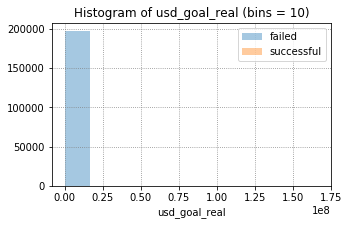

→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する

▼ 対数変換したusd_goal_realの分布


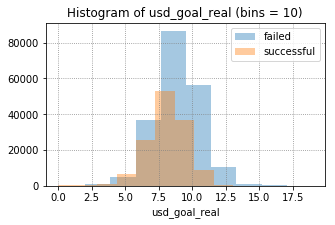

→全体的に目標金額が高くなると失敗しやすくなりそう。


In [7]:
# 外れ値がないか散布図で確認
show_scatter_plot('usd_goal_real',5,3)
print('→目標金額が高すぎるものは、失敗している。')
# 目標金額の分布
show_histogram('usd_goal_real',5,3,10)
print('→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する')
show_histogram_log1p('usd_goal_real',5,3,10)
print('→全体的に目標金額が高くなると失敗しやすくなりそう。')

### 2-3-4. 開始時期（launched_month、launched_day、launched_hour）


▼ launched_month別の成功数と失敗数


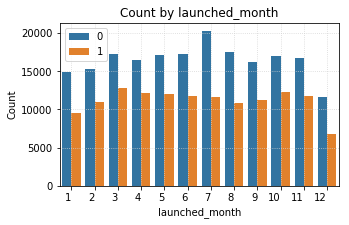


▼ launched_month別の成功率 ※赤線：学習データの平均成功率


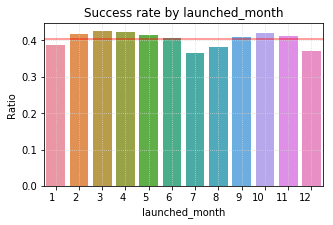

→春と秋あたりに開始すると成功率が若干高まる。

▼ launched_day別の成功数と失敗数


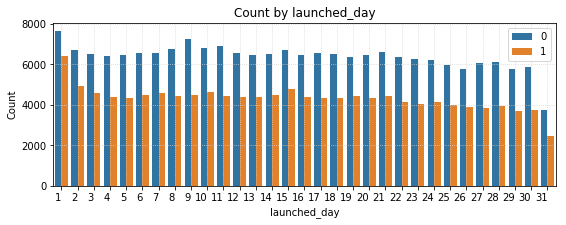


▼ launched_day別の成功率 ※赤線：学習データの平均成功率


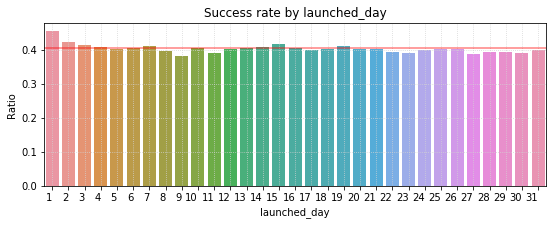

→月の上旬（特に1日開始）の成功率が若干高い。

▼ launched_hour別の成功数と失敗数


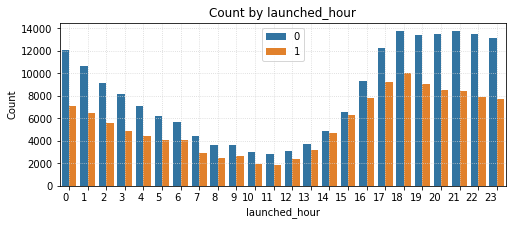


▼ launched_hour別の成功率 ※赤線：学習データの平均成功率


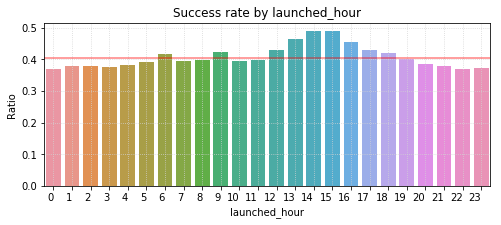

→午後2,3時あたりに開始すると成功率が高まるようだ。


In [8]:
show_state_count_plot('launched_month',5,3)
show_successrate_barplot('launched_month',5,3,baseline)
print('→春と秋あたりに開始すると成功率が若干高まる。')

show_state_count_plot('launched_day',9,3)
show_successrate_barplot("launched_day",9,3,baseline)
print('→月の上旬（特に1日開始）の成功率が若干高い。')

show_state_count_plot('launched_hour',8,3)
show_successrate_barplot("launched_hour",8,3,baseline)
print('→午後2,3時あたりに開始すると成功率が高まるようだ。')

### 2-3-5. 終了時期（deadline_month、deadline_day）


▼ deadline_month別の成功数と失敗数


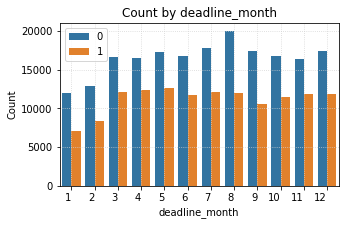


▼ deadline_month別の成功率 ※赤線：学習データの平均成功率


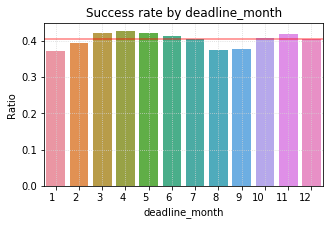


▼ deadline_day別の成功数と失敗数


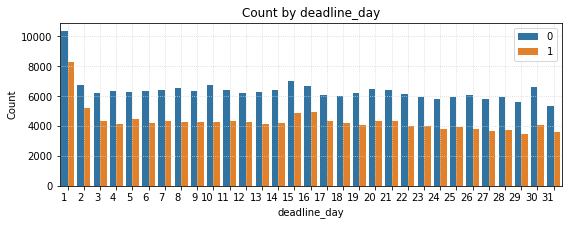


▼ deadline_day別の成功率 ※赤線：学習データの平均成功率


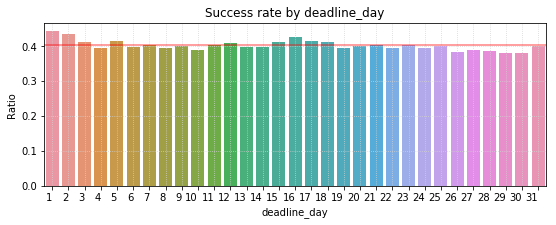

In [9]:
show_state_count_plot('deadline_month',5,3)
show_successrate_barplot('deadline_month',5,3,baseline)

show_state_count_plot('deadline_day',9,3)
show_successrate_barplot("deadline_day",9,3,baseline)

### 2-3-6. 主なカテゴリとカテゴリ（main_category、category）


▼ main_categoryとcategory別のカウントと成功率


state          
                             count      mean
main_category category                      
Art           Art             7486  0.452177
              Ceramics         275  0.480000
              Conceptual Art   930  0.393548
              Digital Art     1171  0.316823
              Illustration    2890  0.562630
              Installations    436  0.534404
              Mixed Media     2513  0.376045
...                            ...       ...
Theater       Experimental     342  0.616959
              Festivals        512  0.630859
              Immersive        297  0.569024
              Musical          830  0.556627
              Plays           1291  0.622773
              Spaces           194  0.510309
              Theater         6684  0.659037

[170 rows x 2 columns]

→main_categoryとcategoryは別々で考慮したほうが良さそう。

▼ main_category別の成功数と失敗数（降順）


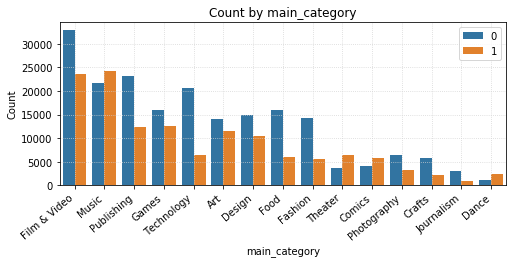


▼ main_category別の成功率（降順）※赤線：学習データの平均成功率


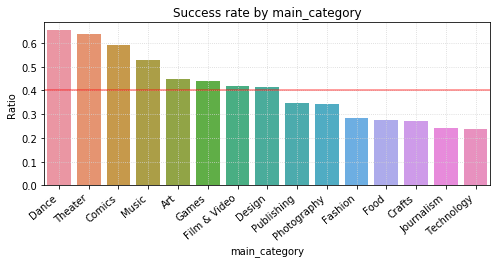

→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。

▼ category別の成功数と失敗数（降順）


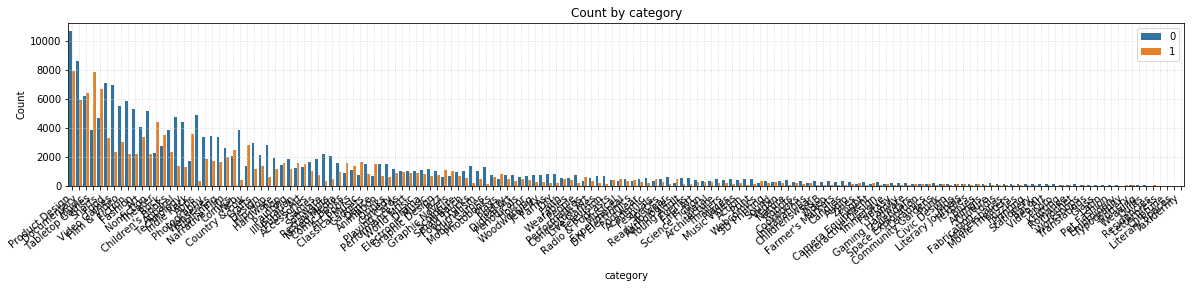


▼ category件数順（Top10）


,category
Product Design,18680
Documentary,14523
Music,12633
Tabletop Games,11744
Shorts,11394
Food,10416
Video Games,9328
Film & Video,8624
Fiction,8108
Fashion,7529



▼ category別の成功率（降順）※赤線：学習データの平均成功率


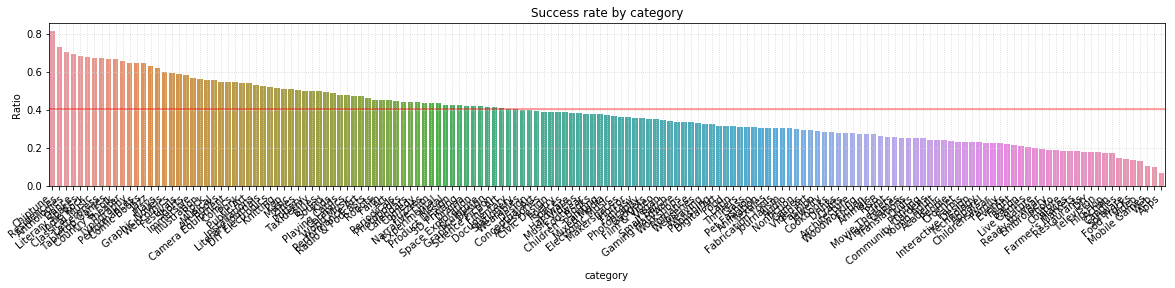


▼ category成功率順（Top10）


,state
category,
Chiptune,0.818182
Residencies,0.735294
Anthologies,0.706920
Dance,0.695221
Literary Spaces,0.684211
Indie Rock,0.678927
Classical Music,0.675000
Letterpress,0.673913
Tabletop Games,0.669789


→成功しやすいcategoryと失敗しやすいcategoryがありそう。


In [10]:
# main_categoryとcategoryの関係
print('\n▼ main_categoryとcategory別のカウントと成功率')
df_category = df[['main_category','category','state']]

display(df_category.groupby(['main_category', 'category']).agg(['count','mean']))
print('→main_categoryとcategoryは別々で考慮したほうが良さそう。')

# main_category
show_state_count_plot('main_category',8,3, True,40)
show_successrate_barplot('main_category',8,3, baseline,True,40)
print('→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。')

# category
show_state_count_plot('category',20,3, True,40)

print('\n▼ category件数順（Top10）')
display(pd.DataFrame(df['category'].value_counts(),columns=['category']).head(10))

show_successrate_barplot('category',20,3, baseline,True,40)

print('\n▼ category成功率順（Top10）')
successrate = pd.DataFrame(df['state'].groupby(df['category']).mean())
successrate_s = successrate.sort_values('state', ascending=False) # 成功率降順
display(successrate_s.head(10))

print('→成功しやすいcategoryと失敗しやすいcategoryがありそう。')

### 2-3-7. 通貨と開催国（currency、country）

→country=N,0"となっているデータは、除外する

▼ currencyとcountry別のカウントと成功率


state          
                   count      mean
currency country                  
AUD      AU         6616  0.303809
CAD      CA        12370  0.334196
CHF      CH          652  0.286810
DKK      DK          926  0.388769
EUR      AT          485  0.220619
         BE          523  0.290631
         DE         3436  0.272701
...                  ...       ...
JPY      JP           23  0.304348
MXN      MX         1411  0.280652
NOK      NO          582  0.278351
NZD      NZ         1274  0.351648
SEK      SE         1509  0.337309
SGD      SG          454  0.392070
USD      US       261360  0.418193

[22 rows x 2 columns]


▼ currency別の成功数と失敗数（降順）


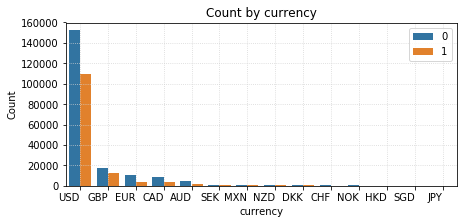


▼ currency別の成功率（降順）※赤線：学習データの平均成功率


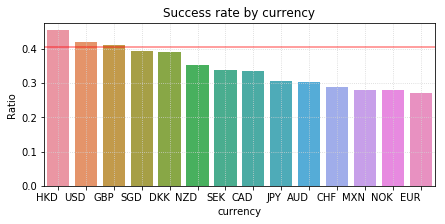


▼ country別の成功数と失敗数（降順）


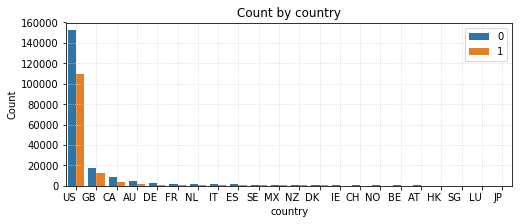


▼ country別の成功率（降順）※赤線：学習データの平均成功率


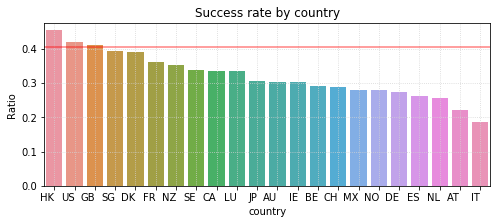

→currencyとcountryは関連しているので、どちらか一方でよいかも。


In [11]:
print('→country=N,0\"となっているデータは、除外する')
df = df[(df['country'] != 'N,0"')]

# currencyとcountryの関係を確認
print('\n▼ currencyとcountry別のカウントと成功率')

df_currency = df[['currency','country','state']]
display(df_currency.groupby(['currency','country']).agg(['count','mean']))

# currency
show_state_count_plot('currency',7,3,True)
show_successrate_barplot('currency',7,3,baseline,True)

# country
show_state_count_plot('country',8,3,True)
show_successrate_barplot('country',8,3,baseline,True)

print('→currencyとcountryは関連しているので、どちらか一方でよいかも。')

### 2-3-8. 名称の文字数と単語数、最終文字（name_char_length／name_word_num／name_end_char）


▼ 最終文字の種類
Other    290503
!         26274
.         13184
?          1504
Name: name_end_char, dtype: int64
→nameの最終文字を「!」と「?」と「.」とそれ以外「Other」に分割して比較する。

▼ name_end_char別の成功数と失敗数


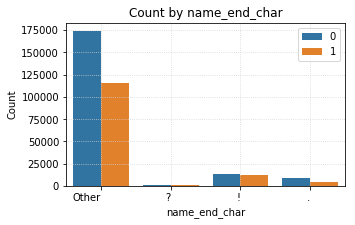


▼ name_end_char別の成功率 ※赤線：学習データの平均成功率


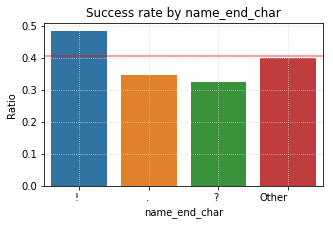

→「！」で終わらすのがよさそう。

▼ name_char_lengthの分布 ※歪度：0.12788269527244372


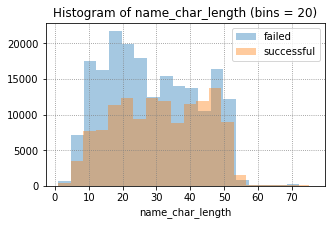

→文字数が少ないと失敗しやすいように見える。

▼ name_char_length別の成功数と失敗数


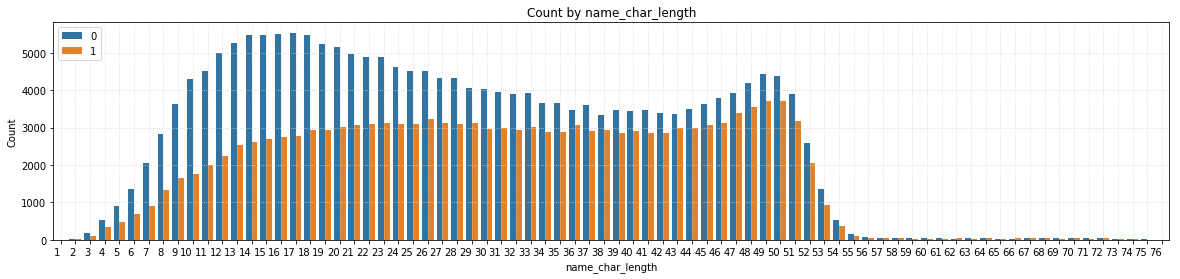


▼ name_char_length別の成功率 ※赤線：学習データの平均成功率


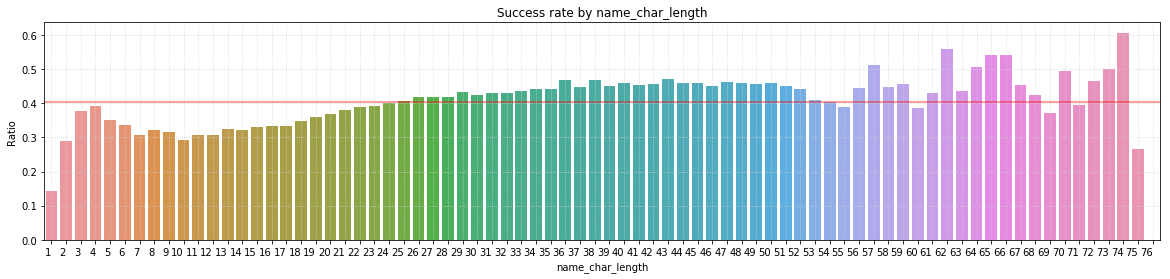

→若干は、成功しやすさの要因になると考えられる。

▼ name_word_numの分布 ※歪度：0.36251766330208274


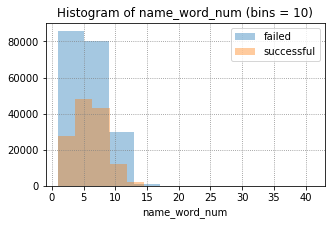


▼ name_word_num別の成功数と失敗数


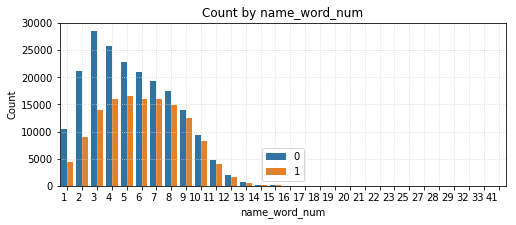


▼ name_word_num別の成功率 ※赤線：学習データの平均成功率


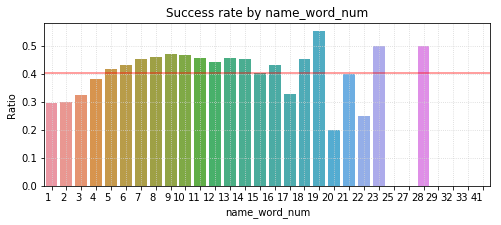

In [12]:
# 最終文字の種類をグループ分けする
df.name_end_char = np.where((df.name_end_char!='!') & (df.name_end_char!='?') & (df.name_end_char!='.'),
                            'Other',df.name_end_char)

print('\n▼ 最終文字の種類')
print(df.name_end_char.value_counts())
print('→nameの最終文字を「!」と「?」と「.」とそれ以外「Other」に分割して比較する。')
show_state_count_plot('name_end_char',5,3)
show_successrate_barplot('name_end_char',5,3,baseline)
print('→「！」で終わらすのがよさそう。')

show_histogram('name_char_length',5,3,20)
print('→文字数が少ないと失敗しやすいように見える。')
show_state_count_plot('name_char_length',20,4)
show_successrate_barplot('name_char_length',20,4,baseline)
print('→若干は、成功しやすさの要因になると考えられる。')

show_histogram('name_word_num',5,3,10)
show_state_count_plot('name_word_num',8,3)
show_successrate_barplot('name_word_num',8,3,baseline)


▼ diff_successful_goal_meanの分布 ※歪度：83.14048254930961


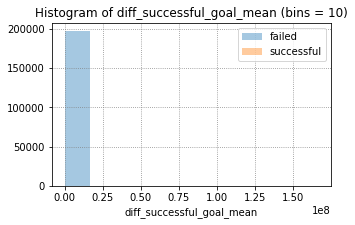

→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する

▼ 対数変換したdiff_successful_goal_meanの分布


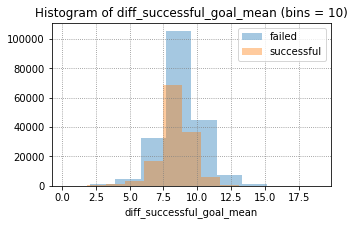

→目標金額と同じようなヒストグラムになった。


In [13]:
# カテゴリ別の成功したプロジェクトの平均目標金額(successful_goal_mean)を算出
tb1 = df[df['state']==1][['category','usd_goal_real']]
tb1 = tb1.reset_index(drop=True).rename(columns={"usd_goal_real" : "successful_goal_mean"})
tb1_sub = tb1.groupby('category').mean()
df = df.merge(tb1_sub, on = 'category')

# 各プロジェクトの目標金額との絶対値の差額（diff_successful_goal_mean）を算出
df['diff_successful_goal_mean'] = abs(df.successful_goal_mean - df.usd_goal_real)
df = df.drop(['successful_goal_mean'], axis=1)

# グラフで確認
show_histogram('diff_successful_goal_mean',5,3,10)
print('→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する')
show_histogram_log1p('diff_successful_goal_mean',5,3,10)
print('→目標金額と同じようなヒストグラムになった。')

## 2-4. 無相関化（name_word_numとname_char_length）


▼ name_word_num と name_char_length の相関 ※相関係数: 0.877


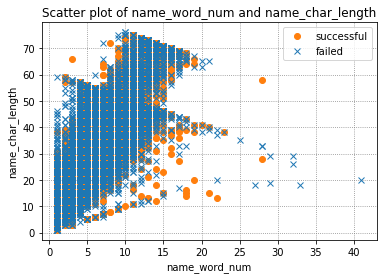

→無相関化する

▼ name_word_num と name_char_length の相関 ※相関係数: -0.000


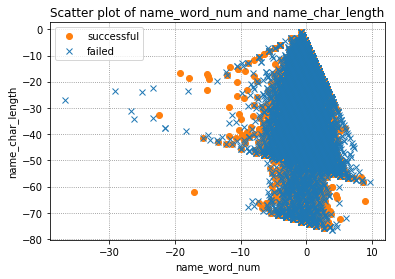

In [14]:
# 相関関係の散布図
show_corr_scatter_plot('name_word_num','name_char_length',6,4)

if(decorr_flg):
    # 無相関化する場合
    print('→無相関化する')
    f_write('│無相関化する')
    cov_data = df[['name_word_num','name_char_length']].values
    cov = np.cov(cov_data, rowvar=0)            # 分散・共分散を求める
    _, S = np.linalg.eig(cov)                   # 分散共分散行列の固有ベクトルを用いて
    cov_data_decorr = np.dot(S.T, cov_data.T).T # データを無相関化

    df['name_word_num'] = cov_data_decorr[:,0]
    df['name_char_length'] = cov_data_decorr[:,1]

    # 無相関化後の散布図
    show_corr_scatter_plot('name_word_num','name_char_length',6,4)
else:
    # 無相関化しない場合
    print('→無相関化しない')
    f_write('│無相関化しない')

## 2-5. 目的変数と説明変数の相関関係


▼ stateと説明変数（数値項目）の相関関係を確認


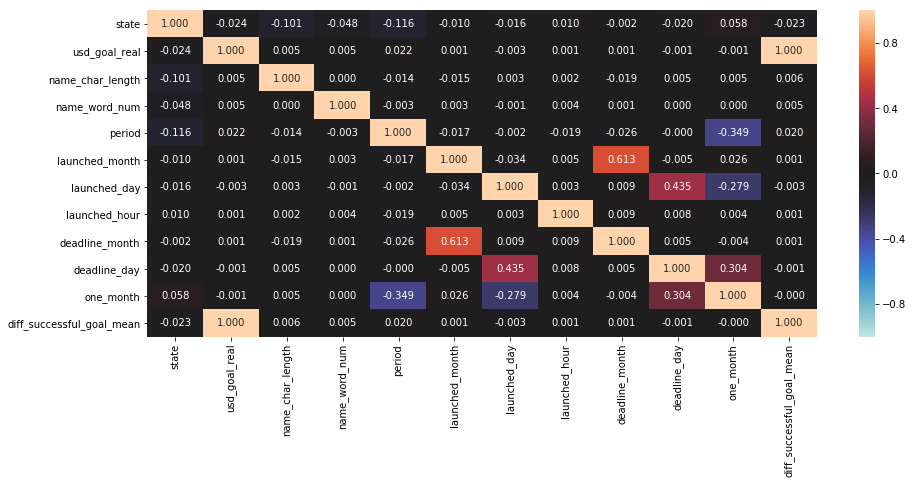

→stateと強い相関があるものはなさそう。


In [15]:
print('\n▼ stateと説明変数（数値項目）の相関関係を確認')
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.show()
print('→stateと強い相関があるものはなさそう。')

# 3. データ前処理<a id='prepearing'></a>
## 3-1. 説明変数の組み合わせを制御

In [16]:
# データ絞り込む為、念のためシャッフル
tmp_df = df.iloc[np.random.RandomState(seed=1234).permutation(len(df))]

# 計算時間を考慮してデータ絞込
if squeeze_num > 0:
    tmp_df = tmp_df[0:squeeze_num]
    
# 標準化＆白色化する項目リスト
enc_norm_col = ['usd_goal_real',
                'name_char_length',
                'name_word_num',
                'period',
                'diff_successful_goal_mean',
               ]

# カテゴリ項目組み合わせ制御（除外するしない、ダミー変換するしない)
enc_dic = {'main_category':[0,1],
           'category':[0,1],
           'country':[0,1],
           'currency':[0,1],
           'launched_month':[0,1],
           'deadline_month':[0,1],
           'launched_day':[0,1],
           'deadline_day':[0,1],
           'launched_hour':[0,1],
           'period':[0,0],             # ←one-hot変換しない場合は、標準化リストに追加すること
           'name_end_char':[0,1],
          }

# カテゴリ項目リスト生成
list_one_hot_cols = []
for k, v in enc_dic.items():
    if(v[0]==1): # drop
        tmp_df = tmp_df.drop(k,axis=1)
        print(k + ' is dropped. ')
        f_write('│' + k + ' を説明変数から除外')
    else:
        if(v[1]==1): # one-hot-encoding
            list_one_hot_cols.append(k)
    
print('\n▼ 行列')
print('tmp_df=',tmp_df.shape)

print('\n▼ 先頭3行表示')
display(tmp_df.head(3))


▼ 行列
tmp_df= (11000, 17)

▼ 先頭3行表示


,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,name_end_char,period,launched_month,launched_day,launched_hour,deadline_month,deadline_day,one_month,diff_successful_goal_mean
57927,Tabletop Games,Games,GBP,1,GB,23435.67,-39.442850,1.123214,Other,30,5,29,21,6,29,0,13509.632731
225154,Gadgets,Technology,EUR,1,IE,2230.80,-32.197090,1.829589,!,34,2,14,22,3,20,0,24352.888331
145482,Photography,Photography,USD,0,US,450.00,-26.475363,-0.234834,Other,44,4,17,3,6,1,0,5250.548923


## 3-2. データ分割（[ホールドアウト法](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)）

In [17]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(tmp_df.drop('state', axis=1), tmp_df['state'],
                                                                test_size=0.3, random_state=1234)

print('\n▼ データ分割後行列')
print('X_train_df=',X_train_df.shape)
print('y_train_df=',y_train_df.shape)
print('X_test_df=',X_test_df.shape)
print('y_test_df=',y_test_df.shape)

print('\n▼ 先頭3行表示')
display(tmp_df.head(3))


▼ データ分割後行列
X_train_df= (7700, 16)
y_train_df= (7700,)
X_test_df= (3300, 16)
y_test_df= (3300,)

▼ 先頭3行表示


,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,name_end_char,period,launched_month,launched_day,launched_hour,deadline_month,deadline_day,one_month,diff_successful_goal_mean
57927,Tabletop Games,Games,GBP,1,GB,23435.67,-39.442850,1.123214,Other,30,5,29,21,6,29,0,13509.632731
225154,Gadgets,Technology,EUR,1,IE,2230.80,-32.197090,1.829589,!,34,2,14,22,3,20,0,24352.888331
145482,Photography,Photography,USD,0,US,450.00,-26.475363,-0.234834,Other,44,4,17,3,6,1,0,5250.548923


## 3-3. [カテゴリ変換](https://contrib.scikit-learn.org/categorical-encoding/onehot.html)

In [18]:
# one-hot-encoding
ce_ohe = ce.OneHotEncoder(cols=list_one_hot_cols, use_cat_names=True)
enc_X_train_df = ce_ohe.fit_transform(X_train_df)
enc_X_test_df = ce_ohe.transform(X_test_df)

print('\n▼ カテゴリ変換後行列')
print('enc_X_train_df=',enc_X_train_df.shape)
print('enc_X_test_df=',enc_X_test_df.shape)

print('\n▼ カテゴリ変換後')
display(enc_X_train_df.head(5))


▼ カテゴリ変換後行列
enc_X_train_df= (7700, 326)
enc_X_test_df= (3300, 326)

▼ カテゴリ変換後


,category_Radio & Podcasts,category_Hardware,category_Sound,category_Pop,category_Product Design,category_Photography,category_Fine Art,category_Children's Books,category_Hip-Hop,category_Music,category_Illustration,category_Journalism,category_Indie Rock,category_Performances,category_Documentary,category_Video Games,category_Apparel,category_Footwear,category_Tabletop Games,category_Theater,category_Fashion,category_Restaurants,category_Fantasy,category_Comics,category_Food,category_Webseries,category_Film & Video,category_Nonfiction,category_Country & Folk,category_Sculpture,category_Woodworking,category_Nature,category_Electronic Music,category_Horror,category_Fiction,category_Food Trucks,category_Crafts,category_Animation,category_Art,category_Painting,category_Drama,category_Public Art,category_Comic Books,category_Narrative Film,category_Web,category_Publishing,category_Mobile Games,category_Festivals,category_Academic,category_Gadgets,category_Conceptual Art,category_Digital Art,category_Shorts,category_Games,category_Farms,category_Playing Cards,category_Rock,category_Audio,category_Graphic Novels,category_Dance,category_Family,category_Classical Music,category_Plays,category_Graphic Design,category_Glass,category_Comedy,category_Spaces,category_Design,category_Ready-to-wear,category_Camera Equipment,category_Jazz,category_Flight,category_Periodicals,category_Architecture,category_Apps,category_Zines,category_Print,category_Ceramics,category_People,category_Faith,category_World Music,category_Animals,category_Jewelry,category_Crochet,category_Events,category_Live Games,category_Metal,category_Webcomics,category_Photobooks,category_Technology,category_3D Printing,category_Places,category_Poetry,category_Robots,category_Anthologies,category_Workshops,category_Music Videos,category_Software,category_DIY Electronics,category_Performance Art,category_Young Adult,category_Mixed Media,category_Drinks,category_Civic Design,category_Small Batch,category_Wearables,category_Candles,category_Latin,category_Television,category_Thrillers,category_R&B,category_Accessories,category_Experimental,category_Space Exploration,category_Calendars,category_Art Books,category_Community Gardens,category_Science Fiction,category_Typography,category_Video Art,category_Kids,category_Action,category_DIY,category_Movie Theaters,category_Stationery,category_Makerspaces,category_Textiles,category_Musical,category_Punk,category_Photo,category_Farmer's Markets,category_Cookbooks,category_Puzzles,category_Gaming Hardware,category_Blues,category_Translations,category_Vegan,category_Bacon,category_Video,category_Interactive Design,category_Immersive,category_Installations,category_Knitting,category_Childrenswear,category_Fabrication Tools,category_Weaving,category_Literary Journals,category_Pottery,category_Taxidermy,category_Quilts,category_Embroidery,category_Pet Fashion,category_Residencies,category_Letterpress,category_Printing,category_Couture,category_Romance,main_category_Publishing,main_category_Technology,main_category_Music,main_category_Design,main_category_Photography,main_category_Art,main_category_Journalism,main_category_Dance,main_category_Film & Video,main_category_Games,main_category_Fashion,main_category_Theater,main_category_Food,main_category_Comics,main_category_Crafts,currency_USD,currency_AUD,currency_GBP,currency_CAD,currency_EUR,currency_MXN,currency_NZD,currency_NOK,currency_SGD,currency_DKK,currency_HKD,currency_SEK,currency_CHF,country_US,country_AU,country_GB,country_CA,country_ES,country_MX,country_NZ,country_NO,country_IT,country_SG,country_FR,country_DK,country_NL,country_DE,country_IE,country_LU,country_HK,country_SE,country_AT,country_CH,country_BE,usd_goal_real,name_char_length,name_word_num,name_end_char_!,name_end_char_Other,name_end_char_.,name_end_char_?,period,launched_month_6.0,launched_month_9.0,launched_month_2.0,launched_month_7.0,launched_month_11.0,launched_month_4.0,launched_month_8.0,launched_month_5.0,laun

## 3-4. [標準化](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


▼ndarray変換
X_train.shape= (7700, 326)
X_test.shape= (3300, 326)

▼標準化対象列
{'usd_goal_real': 206, 'name_char_length': 207, 'name_word_num': 208, 'period': 213, 'diff_successful_goal_mean': 325}

▼標準化


<Figure size 432x288 with 0 Axes>

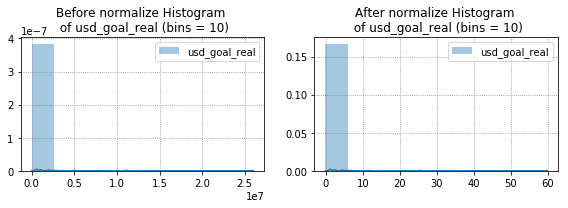

<Figure size 432x288 with 0 Axes>

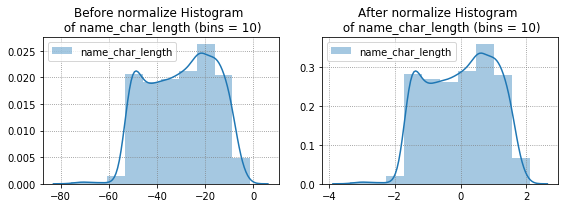

<Figure size 432x288 with 0 Axes>

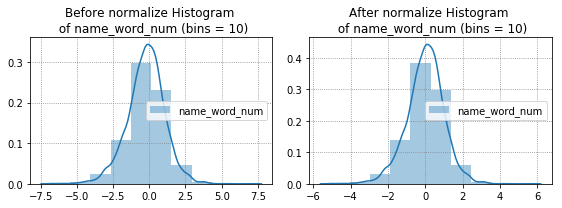

<Figure size 432x288 with 0 Axes>

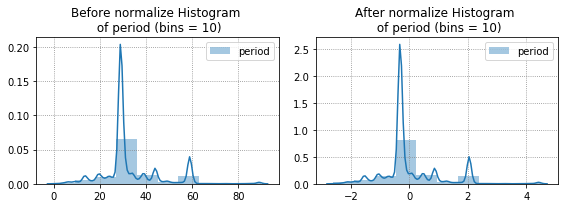

<Figure size 432x288 with 0 Axes>

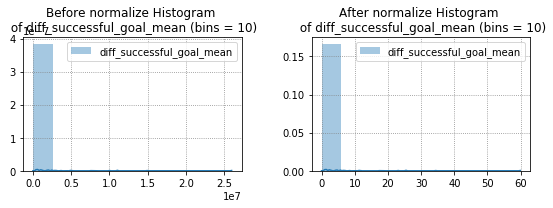

In [19]:
# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, enc_X_train_df.columns.get_loc(col_name)) # 列名から列番号を取得する

# 説明変数リスト
X_columns = enc_X_train_df.columns
list_X_columns = X_columns.tolist()

# ndarrayに変換
X_train = enc_X_train_df.values
y_train = y_train_df.values
X_test = enc_X_test_df.values
y_test = y_test_df.values

print('\n▼ndarray変換')
print('X_train.shape=',X_train.shape)
print('X_test.shape=',X_test.shape)

print('\n▼標準化対象列')
print(dic_norm_col)

print('\n▼標準化')
for col_name,col_idx in dic_norm_col.items():
    
    plt.subplots_adjust(wspace=8.0, hspace=2.0) # 余白
    plt.figure(figsize=(8,3))
    
    # 標準化前
    plt.subplot(1,2,1)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('Before normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    
    # 標準化
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
    #　標準化後
    plt.subplot(1,2,2)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('After normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.tight_layout() # 重ならないように
    plt.show()

# 4. 特徴選択<a id='selection'></a>
## 4-1. ラッパー法（ステップワイズ法）

In [20]:
if(wrapper_flg):
    print('→ラッパー法（ステップワイズ法）を実施する')
    f_write('│ラッパー法（ステップワイズ法）を実施する')
    
    # RFECVは交差検証によってステップワイズ法による特徴選択を行う
    kfold = KFold(n_splits=10, random_state=1234)
    estimator = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
    rfecv = RFECV(estimator, cv=kfold, scoring='accuracy')
    rfecv.fit(X_train, y_train)

    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    print(plt.show())

    remove_feature = X_columns[ ~rfecv.support_]
    for f in remove_feature:
        list_X_columns.remove(f)
        print('│' + f + ' is dropped. ')

    print('\n▼利用対象の特徴数')
    print('len(list_X_columns)=',len(list_X_columns))   

    X_train = X_train[:,rfecv.support_]
    X_test = X_test[:,rfecv.support_]

    print('\n▼ ラッパー法実施後行列')
    print('X_train=',X_train.shape)
    print('X_test=',X_test.shape)
else:
    print('→ラッパー法（ステップワイズ法）しない')
    f_write('│ラッパー法（ステップワイズ法）しない')

→ラッパー法（ステップワイズ法）しない


## 4-2. 埋め込み法

→埋め込み法を実施する

▼ 重みの大きさを横棒グラフで表示(Top15)


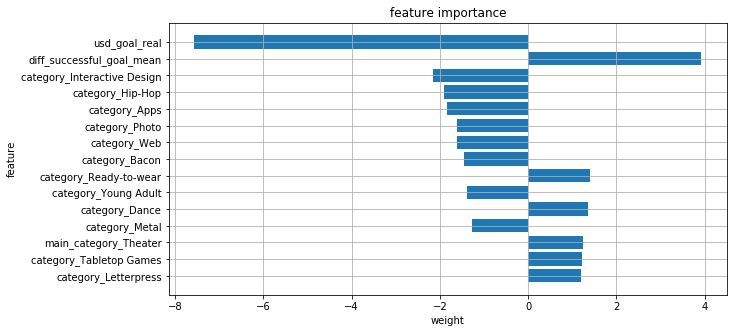


▼利用対象の特徴数
len(list_X_columns)= 207

▼ 埋め込み法実施後行列
X_train= (7700, 207)
X_test= (3300, 207)


In [21]:
if(selectFromModel_flg):
    print('→埋め込み法を実施する')
    f_write('│埋め込み法を実施する')
    
    # L1正則化によって、特徴選択を行う
    clf = SGDClassifier(loss='log',alpha=0.0001, penalty='l1',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
    sfm = SelectFromModel(clf, threshold=1e-5)
    sfm.fit(X_train, y_train)
    
    # 結果をDataFrameへ格納
    res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
    res_df['feature'] = list_X_columns
    res_df['weight'] = np.reshape(sfm.estimator_.coef_[0], -1).tolist()
    res_df['abs_w'] = abs( res_df['weight'] )

    # 重みの大きさを横棒グラフで表示
    print('\n▼ 重みの大きさを横棒グラフで表示(Top15)')
    res_df = res_df.sort_values('abs_w', ascending=False)
    res_df.reset_index(drop=True,inplace=True)
    res_df_head = res_df.head(15)
    plt.figure(figsize=(10, 5))
    plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
    plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
    plt.title('feature importance')
    plt.xlabel('weight')
    plt.ylabel('feature')
    plt.grid()
    plt.show()
    
    remove_feature = X_columns[ ~sfm.get_support()]
    for f in remove_feature:
        list_X_columns.remove(f)
        f_write('│' + f + ' is dropped. ')

    print('\n▼利用対象の特徴数')
    print('len(list_X_columns)=',len(list_X_columns))   

    X_train = X_train[:,sfm.get_support()]
    X_test = X_test[:,sfm.get_support()]
    
    print('\n▼ 埋め込み法実施後行列')
    print('X_train=',X_train.shape)
    print('X_test=',X_test.shape)
else:
    print('→埋め込み法を実施しない')
    f_write('│埋め込み法を実施しない')

# 5. モデル構築<a id='modeling'></a>

In [22]:
dic_argo = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)

## 5-1. パラメーターチューニング

### 5-1-1. [ロジスティック回帰](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [23]:
lr_clf = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
lr_param = {'penalty' : ['None','l1','l2','elasticnet'],#正則化項（default = 'l2'）
            'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
            }
best_lr = grid_search_argo(dic_argo, 'logisticRegression', lr_clf, lr_param, X_train, y_train)

best_lr

BestScore: 0.668961 using {'alpha': 0.001, 'penalty': 'None'}


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='None',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

### 5-1-2. [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [24]:
'''
svm_clf = SVC(random_state=1234)
svm_param = [{'kernel': ['linear'], 'C': [0.1,1]},
                  {'kernel': ['rbf'], 'gamma': [0.1, 1e-2],'C': [0.1,1]}
                 ]
best_svm = grid_search_argo(dic_argo, 'SVM', svm_clf, svm_param, X_train, y_train)

best_svm
'''

"\nsvm_clf = SVC(random_state=1234)\nsvm_param = [{'kernel': ['linear'], 'C': [0.1,1]},\n                  {'kernel': ['rbf'], 'gamma': [0.1, 1e-2],'C': [0.1,1]}\n                 ]\nbest_svm = grid_search_argo(dic_argo, 'SVM', svm_clf, svm_param, X_train, y_train)\n\nbest_svm\n"

### 5-1-3. [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [25]:
dt_clf = DecisionTreeClassifier(random_state=1234)
dt_param = {'criterion':['gini'],             # default=gini
            'splitter':['best','random'],     # default='best' 各ノードで分割を選択するために使用される戦略
            'max_depth' : [9],                # 木の深さ
            'min_samples_split': [2,3],       # ノードを分割するために必要な最小サンプルサイズ
            'min_samples_leaf':[1,3],         # 葉を構成するのに必要な最小限のサンプルの数
            'min_weight_fraction_leaf':[0.0], # default=0.0 ノードに存在する必要がある重みの合計の最小重み付き割合
            'max_features':[None],            # 決定木を成長させる際に利用する特徴変数の数
            'max_leaf_nodes':[None],          # 最高の方法で木を育てます
            'min_impurity_decrease':[0.0]     # この値以上の不純物の減少を引き起こす場合、ノードが分割される
            }
best_dt = grid_search_argo(dic_argo, 'DecisionTree', dt_clf, dt_param, X_train, y_train)

best_dt

BestScore: 0.646104 using {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='random')

## 5-2. ハイパーパラメータチューニング（アンサンブル）
### 5-2-1. [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [26]:
RFC_clf = RandomForestClassifier(random_state=1234)
RFC_param = {'max_depth': [20], # 木の深さ
             'min_samples_split': [3], # ノードを分割するために必要な最小サンプルサイズ
             'min_samples_leaf': [1], # 葉を構成するのに必要な最小限のサンプルの数
             'max_features':[40], # 決定木を成長させる際に利用する特徴変数の数
             'n_estimators' :[500],
            }
best_RFC = grid_search_argo(dic_argo, 'RandomForest', RFC_clf, RFC_param, X_train, y_train)

best_RFC

BestScore: 0.673247 using {'max_depth': 20, 'max_features': 40, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

### 5-2-2. [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [27]:
ABC_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=1234), random_state=1234)
ABC_param = {"base_estimator__criterion" : ["gini"],
             'base_estimator__max_depth': [8],         # 木の深さ
             'base_estimator__min_samples_split': [2], # ノードを分割するために必要な最小サンプルサイズ
             'base_estimator__min_samples_leaf': [3],  # 葉を構成するのに必要な最小限のサンプルの数
             'base_estimator__max_features':[40],      # 決定木を成長させる際に利用する特徴変数の数
             'n_estimators':[1000],                    # ブースティングする木の数
             'learning_rate': [0.001]                  # 学習率
            }
best_ABC = grid_search_argo(dic_argo, 'AdaBoost', ABC_clf, ABC_param, X_train, y_train)

best_ABC

BestScore: 0.665195 using {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 8, 'base_estimator__max_features': 40, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.001, 'n_estimators': 1000}


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
          learning_rate=0.001, n_estimators=1000, random_state=1234)

### 5-2-3. [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [28]:
GBC_clf = GradientBoostingClassifier(random_state=1234)
GBC_param = {'loss' : ['deviance'],   # 最適化される損失関数
             'n_estimators' : [1200], # ブースティングする木の数
             'learning_rate': [0.05], # 学習率
             'max_depth': [3],        # 木の深さ
             'min_samples_leaf': [5], # 葉を構成するのに必要な最小限のサンプルの数
             'min_samples_split': [2], # 内部ノードを分割するために必要なサンプルの最小数
             'max_features': ['sqrt']  # 最適な分割を探すときに考慮する機能の数
             }
best_GBC = grid_search_argo(dic_argo, 'GradientBoosting', GBC_clf, GBC_param, X_train, y_train)

best_GBC

BestScore: 0.678961 using {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1200}


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1200,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### 5-2-4. [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [29]:
XGB_clf = xgb.XGBClassifier(objective= 'binary:logistic',random_state=1234)
XGB_param = {'learning_rate': [0.08],   # 学習率
             'max_depth': [3],          # 木の深さ
             'min_child_weight': [1],   # 子ノードにおいて観察されるデータの重み付けの合計
             'subsample': [0.6],        # トレーニングインスタンスのサブサンプル率
             'colsample_bytree': [0.8], # 各木を構築するときの列のサブサンプル比
             'n_estimators': [200],     # ブースティングする木の数
             'gamma':[0.1],             # 分割が、損失関数の減少に繋がる場合にのみノードの分割を行う。
             'eta': [0.3],              # 学習率を調整できる。小さくすることで、モデルの頑健性を高めることができる。
            }
best_XGB = grid_search_argo(dic_argo, 'XGBoost', XGB_clf, XGB_param, X_train, y_train)

best_XGB

BestScore: 0.675844 using {'colsample_bytree': 0.8, 'eta': 0.3, 'gamma': 0.1, 'learning_rate': 0.08, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0.1,
       learning_rate=0.08, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=1234,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.6, verbosity=1)

### 5-2-5. [LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [30]:
LGB_clf = lgb.LGBMClassifier(objective='binary',random_state=1234)
LGB_param ={'n_estimators':[200],      # ブースティングする木の数
            'max_depth':[12],          # 木の深さ
            'num_leaves':[14],         # 木の葉の最大数
            'learning_rate':[0.01],    # 学習率
            'colsample_bytree':[0.8],  # 各木を構築するときの列のサブサンプル比
            'subsample':[0.01],        # トレーニングインスタンスのサブサンプル率
            'reg_alpha':[0.01],        # 重みに関するL1正則化項
            'reg_lambda':[0],          # 重みに関するL2正則化項
            'min_split_gain':[0.1],    # ツリーのリーフノードにさらにパーティションを作成するために必要な最小限の損失削減
            }
best_LGB = grid_search_argo(dic_argo, 'LightGBM', LGB_clf, LGB_param, X_train, y_train)

best_LGB

BestScore: 0.667273 using {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 12, 'min_split_gain': 0.1, 'n_estimators': 200, 'num_leaves': 14, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.01}


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.01, max_depth=12,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.1,
        n_estimators=200, n_jobs=-1, num_leaves=14, objective='binary',
        random_state=1234, reg_alpha=0.01, reg_lambda=0, silent=True,
        subsample=0.01, subsample_for_bin=200000, subsample_freq=0)

## 5-3. ハイパーパラメータチューニング（ニューラルネットワーク）
### 5-3-1. [ Neural Network](https://keras.io/ja/layers/core/)

In [31]:
from tensorflow.compat.v1.keras            import Sequential
from tensorflow.compat.v1.keras.layers     import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from keras.wrappers.scikit_learn           import KerasClassifier

def build_nn():
    nn = Sequential()    
    nn.add(Dense(units=32, activation='relu', input_dim=len(list_X_columns)))
    nn.add(Dense(units=128, activation='relu'))
    nn.add(Dense(units=16, activation='relu'))
    nn.add(Dense(units=1, activation='sigmoid'))
    nn.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])    
    return nn

NN_param = dict(nb_epoch= [10,20,30],batch_size= [10,20])
best_NN = grid_search_argo(dic_argo, 'NeuralNetwork',KerasClassifier(build_fn=build_nn,verbose=0), NN_param, X_train, y_train)

y_test_pred_NN =(best_NN.predict(X_test) > 0.5).reshape(-1,)
y_train_pred_NN =(best_NN.predict(X_train) > 0.5).reshape(-1,)
print('score_train=',100 * accuracy_score(y_train, y_train_pred_NN))
print('score_test=',100 * accuracy_score(y_test, y_test_pred_NN))

Using TensorFlow backend.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
BestScore: 0.654156 using {'batch_size': 10, 'nb_epoch': 30}
score_train= 67.77922077922078
score_test= 66.42424242424242


## 5-4. アンサンブル × アンサンブル
### 5-4-1. [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

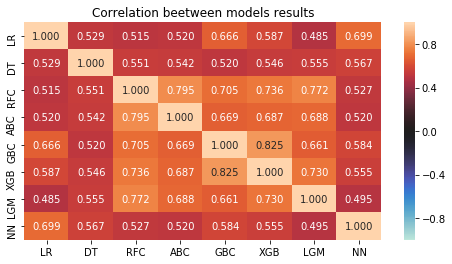

→相関の高いモデル同士を掛け合わせる。


In [32]:
# 各アルゴリズムの予測結果をヒートマップで比較
ensemble_results = pd.concat([pd.Series(best_lr.predict(X_test), name="LR"), 
                              pd.Series(best_dt.predict(X_test), name="DT"), 
                              #pd.Series(best_svm.predict(X_test), name="SVM"), 
                              pd.Series(best_RFC.predict(X_test), name="RFC"),
                              pd.Series(best_ABC.predict(X_test), name="ABC"),
                              pd.Series(best_GBC.predict(X_test), name="GBC"),
                              pd.Series(best_XGB.predict(X_test), name="XGB"),
                              pd.Series(best_LGB.predict(X_test), name="LGM"),
                              pd.Series(y_test_pred_NN, name="NN"),
                             ],axis=1)

plt.figure(figsize =(8, 4))
sns.heatmap(ensemble_results.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.title('Correlation beetween models results', size=12)
plt.show()

print('→相関の高いモデル同士を掛け合わせる。')

In [33]:
# 相関の高いモデル同士を掛け合わせる
VOC_clf = VotingClassifier(estimators=[('gbc', best_GBC),
                                       ('xgb', best_XGB),
                                       ('lgb', best_LGB),
                                      ], n_jobs=-1)

VOC_param = {'voting': ['hard'],'weights':[None]}
best_VOC = grid_search_argo(dic_argo, 'VotingClassifier', VOC_clf, VOC_param, X_train, y_train)

best_VOC

BestScore: 0.676623 using {'voting': 'hard', 'weights': None}


VotingClassifier(estimators=[('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf...01, reg_lambda=0, silent=True,
        subsample=0.01, subsample_for_bin=200000, subsample_freq=0))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

# 6. 学習曲線<a id='learning_curve'></a>
- 本来の学習曲線の横軸は、サンプル数ではなく、イテレーション回数ということですが、scikit-learnのライブラリにあるlearning_curveの場合、理想的なモデルであれば、サンプル数を大きくしたとき、学習データに対する予測精度と評価データに対する予測精度がほぼ同じ値に漸近する。その漸近される値があらかじめ設定した精度よりも高ければ、そのモデルがうまく作られていることを表す。

In [34]:
#plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)
#plot_learning_curve(best_SVM,"SVM learning curves",X_train,y_train,cv=kfold)
#plot_learning_curve(best_RFC,"RandomForest learning curves",X_train,y_train,cv=kfold)
#plot_learning_curve(best_ABC,"AdaBoost learning curves",X_train,y_train,cv=kfold)
#plot_learning_curve(best_XGB,"XGBoost learning curves",X_train,y_train,cv=kfold)
#plot_learning_curve(best_GBC,"GradientBoosting learning curves",X_train,y_train,cv=kfold)
#plot_learning_curve(best_LGB,"LightGBM learning curves",X_train,y_train,cv=kfold)
#plot_learning_curve(best_NN,"Neural Network learning curves",X_train,y_train,cv=kfold)

# 7. 重要な特徴<a id='feature_importance'></a>

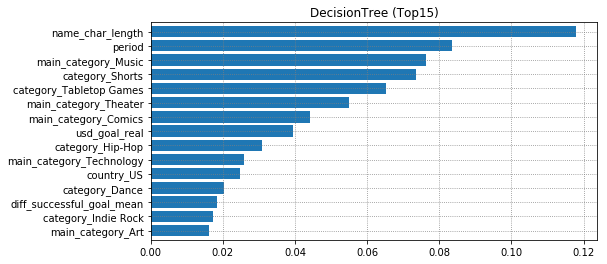

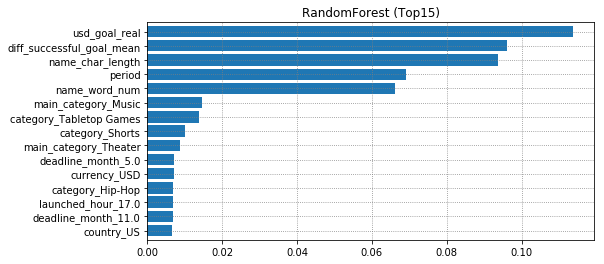

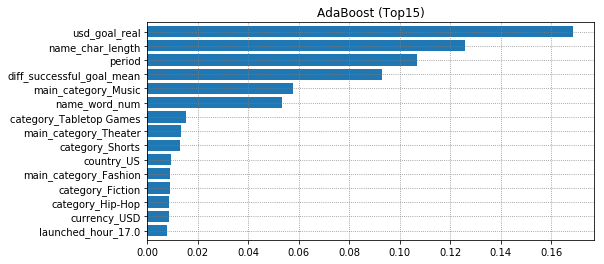

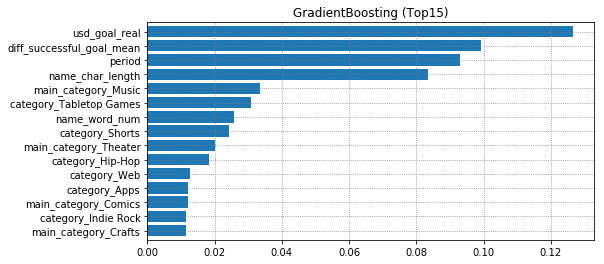

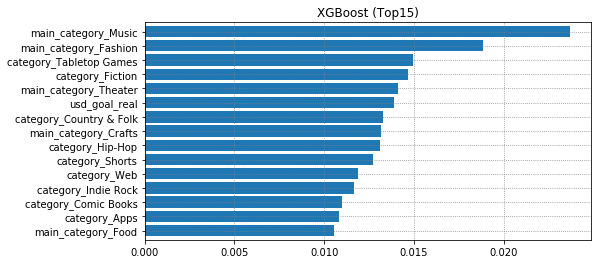

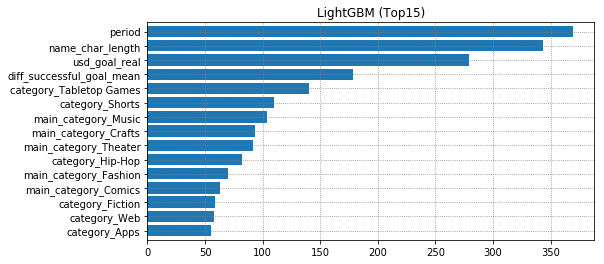

In [35]:
for k,grid_result in dic_argo.items():    
    if(hasattr(grid_result.best_estimator_, 'feature_importances_')):
        plot_feature_importance(grid_result.best_estimator_, list_X_columns, k)

# 8. モデル評価<a id='result'></a>

In [36]:
# 全モデルの評価結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['model_name','train_acc_score','test_acc_score','precision','recall','F1'])

f_write('│▽検証したアルゴリズム数：' + str(len(dic_argo)))

# 全モデル比較
first_flg = True
for k,grid_result in dic_argo.items():
    tmp_score = grid_result.best_score_
    f_write('│' + str(k) + ' :  {:.3f}%'.format(tmp_score * 100))
    
    # 一覧追加
    y_train_pred = grid_result.best_estimator_.predict(X_train)
    y_test_pred = grid_result.best_estimator_.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
    addRow = pd.DataFrame([k, 100 * accuracy_score(y_train, y_train_pred),
                              100 * accuracy_score(y_test, y_test_pred),
                              100 * precision[0],
                              100 * recall[0],
                              100 * f1_score[0]], index=res_df.columns).T
    res_df = res_df.append(addRow, ignore_index=True)
    
    # 最良モデル取得
    if (first_flg):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_
        first_flg = False
    if (max_score < tmp_score):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_

print('\n▼ モデルの評価結果一覧')
display(res_df)

# 最良モデルの評価
y_train_pred = best_clf.predict(X_train) # 訓練データ
y_test_pred = best_clf.predict(X_test) # テストデータ
score_train = 100 * accuracy_score(y_train, y_train_pred)
score_test = 100 * accuracy_score(y_test, y_test_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
v_precision = 100 * precision[0]
v_recall= 100 * recall[0]
v_F1 = 100 * f1_score[0]

print('\n▼ Day3 モデルの評価結果')
print('最良モデル = ' + str(best_model) + '：' + str(best_param))
print('訓練データサイズ = ' + str(X_train.shape))
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
print('正答率（訓練データ） = {:.3f}%'.format(score_train))
print('正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))
print('適合率（Precision※精度) = {:.3f}%'.format(v_precision))
print('再現率（Recall※検出率) = {:.3f}%'.format(v_recall))
print('F1値（F1-score） = {:.3f}%'.format(v_F1))
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])
display(conf_mat)

# 計算時間
proc_time = time() - start_notebook
print('計算時間（分）：{:.2f}'.format(proc_time / 60)) 

# 結果をファイル出力
f_write('│▽最良モデル')
f_write('│' + str(best_model) + '：' + str(best_param))
f_write('│▽使用データ')
f_write('│訓練データサイズ = ' + str(X_train.shape))
f_write('│▽評価結果')
f_write('│対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
f_write('│正答率（訓練データ） = {:.3f}%'.format(score_train))
f_write('│正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))
f_write('│適合率（Precision※精度) = {:.3f}%'.format(v_precision))
f_write('│再現率（Recall※検出率) = {:.3f}%'.format(v_recall))
f_write('│F1値（F1-score） = {:.3f}%'.format(v_F1))
f_write('│計算時間（分）：{:.2f}'.format(proc_time / 60)) 
f_write('▲処理終了')


▼ モデルの評価結果一覧


,model_name,train_acc_score,test_acc_score,precision,recall,F1
0,logisticRegression,69.026,67.0303,70.21,79.7714,74.6859
1,DecisionTree,68.5844,66.0909,67.3938,85.9841,75.5623
2,RandomForest,95.0779,68,69.9001,83.4493,76.0761
3,AdaBoost,88.8701,68,69.7032,84.0457,76.2055
4,GradientBoosting,74.9481,70.0303,73.0302,80.6163,76.636
5,XGBoost,71.8571,69.5152,72.0808,81.6103,76.5501
6,LightGBM,68.8701,67.7879,68.5424,87.1769,76.7447
7,NeuralNetwork,67.7792,66.4242,68.0223,84.7913,75.4867
8,VotingClassifier,72.5844,69.8788,71.8831,83.1014,77.0862



▼ Day3 モデルの評価結果
最良モデル = GradientBoosting：{'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 1200}
訓練データサイズ = (7700, 207)
対数尤度 = -10.351
正答率（訓練データ） = 74.948%
正答率（テストデータ）= 70.030% ※汎化性能
適合率（Precision※精度) = 73.030%
再現率（Recall※検出率) = 80.616%
F1値（F1-score） = 76.636%

▼ 混同行列


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,1622,390
正解 = 資金調達成功,599,689


計算時間（分）：2.50


### ◆気になること
- ニューラルネットワークの精度が思ったほど上がらなかった。

### ────────────────────────────────────────────────────────────────
### ◆これまでの記録

####  Day2 モデルの評価結果（2020.01.15）
- 最良モデル = LogisticRegression：{'alpha': 0.0001, 'penalty': 'l1'}
- 訓練データサイズ = (7700, 407)
- 対数尤度 = -11.314
- 正答率（訓練データ） = 69.286%
- 正答率（テストデータ）= 67.242% ※汎化性能
- 適合率（Precision※精度) = 71.598%
- 再現率（Recall※検出率) = 74.195%
- F1値（F1-score） = 72.873%

#### Day1 モデルの評価結果（2020.01.07）
- ロジスティック回帰モデル（正則化項なし）
- 対数尤度 = -14.931
- 正答率（訓練データ) = 56.772% （標準化なし）
- 適合率（Precision※精度) = 73.061%
- 再現率（Recall※検出率) = 43.540%
- F1値（F1-score） = 54.563%